# Upsampling Quasars

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [60]:
from astroML.datasets import fetch_dr7_quasar

#Fetch the quasar data
data = fetch_dr7_quasar()

#Gathering the first 10000 points
data = data[:10000]

z = data['redshift']

### 1. Rejection Sampling

16207 points were accepted.
33793 points were rejected.
Success rate of 32.41%.


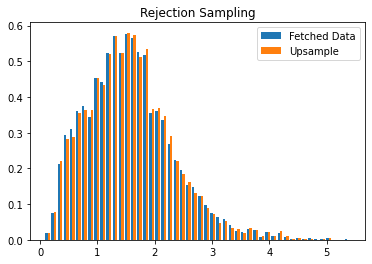

In [61]:
N = 50000
bins = 50

#Creating a numpy histogram
counts, bins = np.histogram(z, bins=bins, density=True)

#Making a scipy random-variable-object histogram, it has a very useful pdf method that allows to evaluate guesses quickly!
mock_hist = scipy.stats.rv_histogram((counts,bins))

xgrid = np.random.uniform(np.min(bins), np.max(bins), N)        #Uniform x draws
y_guess = np.random.uniform(0, np.max(counts), N)               #Uniform y draws

#Accepting guesses with masks
y_mask = tuple([y_guess <= mock_hist.pdf(xgrid)])
acc_upsample = xgrid[y_mask]

#Showing upsample efficiency
print('{} points were accepted.\n{} points were rejected.\nSuccess rate of {:.2f}%.'.format(len(acc_upsample), N-len(acc_upsample), (len(acc_upsample)/N)*100))

plt.title('Rejection Sampling')
plt.hist([z, acc_upsample], bins=bins, density=True, label=['Fetched Data', 'Upsample'])
plt.legend()
plt.show()

### 2. Inverse transform Sampling

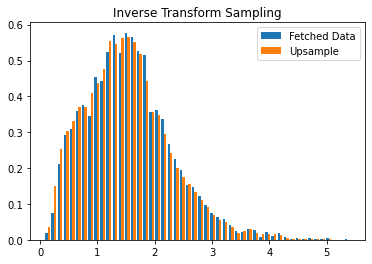

In [62]:
N = 50000
bins = 50

#Creating a numpy histogram
counts, bins = np.histogram(z, bins=bins, density=True)

#Cumulative sum is a very simple choice for a cumulative distribution function
csum_cdf = np.cumsum(counts)/np.sum(counts)

#Centering the bins in the middle of the interval that they cover -> Better interpolation
bins_centered = (bins[1:] + bins[:-1]) / 2

#Interpolating the cdf in order to obtain an evaluable function
try_cdf = scipy.interpolate.interp1d(csum_cdf, bins_centered)

y_sampled = np.random.uniform(min(csum_cdf), max(csum_cdf), N)      #Uniform y draws within the boundaries of the cdf
x_upsampled = try_cdf(y_sampled)                                    #Gathering the equivalent x in respect to the drawn y

plt.title('Inverse Transform Sampling')
plt.hist([z, x_upsampled], bins=bins, density=True, label=['Fetched Data', 'Upsample'])
plt.legend()
plt.show()

### 3. Cosmology of Quasars

In [63]:
import astropy
astropy.cosmology.Planck15

FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)

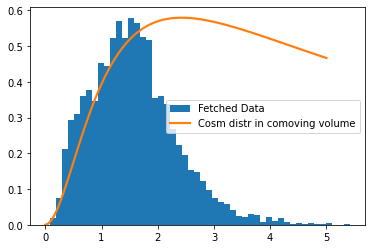

In [78]:
class uniformredshift(object):
    def __init__(self,zmax):
        ''' Lazy loading...'''
        self._norm = None
        self._pdfmax = None
        self.zmax=zmax

    def _eval(self,z_vals):
        '''Unnormalized pdf'''
        return ((4.*np.pi*astropy.cosmology.Planck18.differential_comoving_volume(z_vals).value))


    def norm(self):
        '''Compute normalization'''
        if self._norm is None:
            self._norm = scipy.integrate.quad( self._eval, 0, self.zmax)[0]
        return self._norm


    def eval(self,z_vals):
        return self._eval(z_vals)/self.norm()

        return np.array(zsample)


redshiftpdf = uniformredshift(zmax = 5)
redshift_grid = np.linspace(0,5,100)

plt.hist(z, bins=50, density=True, label='Fetched Data')
plt.plot(redshift_grid, 2.3*redshiftpdf.eval(redshift_grid), label='Cosm distr in comoving volume', linewidth=2.2)
plt.legend()
plt.show()